# Sprint 深層学習スクラッチ ニューラルネットワーク

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
(X_train, t_train), (X_test, t_test) = mnist.load_data()

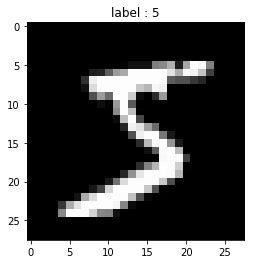

In [3]:
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(t_train[index]))
plt.show()

In [4]:
X_train  = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [5]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [6]:
enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
t_train_one_hot = enc.fit_transform(t_train[:, np.newaxis])
t_test_one_hot = enc.fit_transform(t_test[:,  np.newaxis])

In [7]:
X_train, X_val, t_train, t_val = train_test_split(X_train, t_train_one_hot, test_size=0.2)

In [8]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

## 問題1】重みの初期値を決めるコードの作成
ニューラルネットワークの各層の重みの初期値を決めるコードを作成してください。

重みの初期値は様々な方法が提案されていますが、今回はガウス分布による単純な初期化を行います。バイアスに関しても同様です。

以下のコードを参考にしてください。標準偏差の値sigmaはハイパーパラメータです。発展的な重みの初期化方法については次のSprintで扱います。

## 【問題2】フォワードプロパゲーションの実装
三層のニューラルネットワークの フォワードプロパゲーション を作成してください。以下の説明ではノード数は1層目は400、2層目は200としますが、変更しても構いません。

## 【問題3】交差エントロピー誤差の実装
目的関数（損失関数）を作成します。

多クラス分類の目的関数である交差エントロピー誤差 
L
 は次の数式です。

## 【問題4】バックプロパゲーションの実装
三層のニューラルネットワークのバックプロパゲーションを作成してください。確率的勾配降下法を行う部分です。

数式を以下に示します。

## 【問題5】推定
推定を行うメソッドを作成してください。

## 【問題6】学習と推定
MNISTのデータを学習・推定し、Accuracyを計算してください。

In [24]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器
    Parameters
    -------------------
    
    Attributest
    -------------------
    """
    
    def __init__(self, verbose=False, lr = 0.1, epochs=3, sigma=0.01):
        self.verbose = verbose
        
        self.lr = lr
        self.epochs = epochs
        self.sigma = sigma
        
        self.W1 = self._init_W(784, 400)
        self.W2 = self._init_W(400, 200)
        self.W3 = self._init_W(200, 10)
        
        self.B1  = self.sigma * np.random.randn(400)
        self.B2  = self.sigma * np.random.randn(200)
        self.B3  = self.sigma * np.random.randn(10)
        
        self.cross_entropy_list = []
        self.cross_entropy_list_val = []
        
    def _init_W(self, input_shape, output_shape):
        n_features = input_shape
        n_nodes = output_shape
        sigma = 0.01
        W = sigma * np.random.randn(n_features, n_nodes)
        
        return W
    
    def _tanh(self, X):
        return (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))
    
    def _softmax(self, X):
        softmax_result = np.empty((X.shape[0], X.shape[1]))
        exp_a = np.exp(X)
        exp_sum = np.sum(exp_a, axis=1)
        for i in range(X.shape[0]):
            softmax_result[i] = exp_a[i] / exp_sum[i]
            
        return softmax_result
    
    def _forward(self, X):
        self.a1 = X@self.W1 + self.B1
        self.z1 = self._tanh(self.a1)
        self.a2 = self.z1@self.W2 + self.B2
        self.z2 = self._tanh(self.a2)
        self.a3 = self.z2@self.W3 +self.B3
        self.z3= self._softmax(self.a3)
        
        return self.z3
        
    
    def _back(self,X, t):
        L_A3 = np.average(self.z3 - t, axis=0)
        L_W3 = np.average(self.z2, axis=0).reshape(200, 1) * L_A3
        L_B3 = L_A3.copy()
        L_Z2 = L_A3 @ self.W3.T
        
        ave_a2 = np.average(self.a2, axis=0)
        ave_a2_tanh = self._tanh(ave_a2)
        ave_a2_tanh2 = ave_a2_tanh**2
        ave_a2_tanh2_1 = 1 - ave_a2_tanh2
        L_A2 = (L_Z2 * ave_a2_tanh2_1)
        ave_z1 = np.average(self.z1, axis=0)
        L_W2 = ave_z1.reshape(400, 1) * L_A2
        L_B2 = L_A2.copy()
        L_Z1 = L_A2 @ self.W2.T
        
        ave_a1 = np.average(self.a1, axis=0)
        ave_a1_tanh = self._tanh(ave_a1)
        ave_a1_tanh2= ave_a1_tanh**2
        ave_a2_tanh2_1 = 1 - ave_a1_tanh2
        L_A1 = L_Z1  * ave_a2_tanh2_1
        L_B1 = L_A1.copy()
        ave_X = np.average(X, axis=0)
        L_W1 = ave_X.reshape(784, 1) * L_A1
        
        self.W1 = self.W1 -  self.lr * L_W1
        self.W2 = self.W2 -  self.lr * L_W2
        self.W3 = self.W3 -  self.lr * L_W3
        self.B1 = self.B1 -  self.lr * L_B1
        self.B2 = self.B2 -  self.lr * L_B2
        self.B3 = self.B3 -  self.lr * L_B3
    
    
    def _cross_entropy(self, t):
        return -np.average(np.sum(t*np.log(self.z3), axis=1))
    
    
        
    def fit(self, X, t, X_val=np.array([]), t_val=np.array([])):
        """
        ニューラルネットワーク分類器を学習する。
        Parameters
        -------------------
        X : 次の形のndarray, shape(n_samples, n_features)
        t:次の形のndarray, shape(n_samples, n_features)
        X_val: 訓練用データ　shapeはXと同じ
        t_val:訓練用データ　shapeはtと同じ
        """
        
        for i in range(self.epochs):
            get_mini_batch = GetMiniBatch(X  , t , batch_size=20)
            for X_train_min, t_train_min in get_mini_batch:
                self._forward(X_train_min)
                self._back(X_train_min, t_train_min)
            self._forward(X)
            self.cross_entropy_list.append(self._cross_entropy(t))
        
        if X_val.size != 0:
            self.W1 = self._init_W(784, 400)
            self.W2 = self._init_W(400, 200)
            self.W3 = self._init_W(200, 10)
            self.B1  = self.sigma * np.random.randn(400)
            self.B2  = self.sigma * np.random.randn(200)
            self.B3  = self.sigma * np.random.randn(10)
            for i in range(self.epochs):
                get_mini_batch = GetMiniBatch(X_val , t_val , batch_size=20)
                for X_train_min, t_train_min in get_mini_batch:
                    self._forward(X_train_min)
                    self._back(X_train_min, t_train_min)
                self._forward(X_val)
                self.cross_entropy_list_val.append(self._cross_entropy(t_val))
            
        
            
            
        
        if self.verbose:
            print(self.cross_entropy_list)
    
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------------
        X : 次の形のndarray, shape (n_samples, n_features)
        
        Returns
        ----------------
        y: ndarray ( n_samples, 1)
        """
        y = np.argmax(self._forward(X), axis=1)
        return y
        

In [17]:
snc = ScratchSimpleNeuralNetrowkClassifier()

In [18]:
snc.fit(X_train, t_train)

In [20]:
y = snc.predict(X_test)

In [21]:
print(accuracy_score(t_test, y))

0.7983


## 【問題7】学習曲線のプロット
学習曲線をプロットしてください。

ニューラルネットワークは過学習が発生しやすいため、学習曲線の確認が重要です。trainデータとvalデータに対するエポックごとの損失（交差エントロピー誤差）を記録できるようにする必要があります。

In [25]:
snc2 = ScratchSimpleNeuralNetrowkClassifier(epochs=5, lr= 0.1)

In [26]:
snc2.fit(X_train, t_train, X_val, t_val)

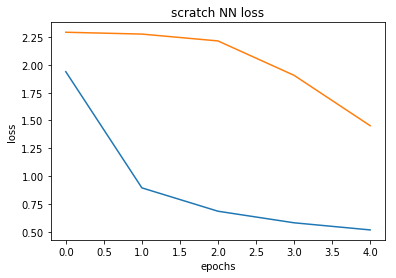

In [28]:
plt.plot(snc2.cross_entropy_list)
plt.plot(snc2.cross_entropy_list_val)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("scratch NN loss")
plt.show()